ToDo: Look into factor analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn import linear_model, preprocessing, pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('../../data/raw/sdBShortP_large_BPS_set.csv')

# Data preparation

In [5]:
# extract the alpha value from the ce_parameters (alpha_ce is always the same as alpha_th)
df['alpha_ce'] = df['ce_parameters'].apply(lambda x: eval(x)['a_ce'])

In [6]:
# Mark systems with a He ignition or burning error as error. ignore other errors.
df['error'] = df['error_flags'].apply(lambda x: 1 if 4 in eval(x) or 5 in eval(x) else 0)

In [7]:
# remove systems that merge or are contact systems (the latter are likely also mergers)
df = df[(df['stability'] != 'merger') & (df['stability'] != 'contact')]

In [8]:
df['product'] = 'UK'

for i, line in df.iterrows():
    
    sdA = line['sdA']
    sdB = line['sdB']
    sdO = line['sdO']
    HeBurn = line['HeCoreBurning']
    HeWD = line['He-WD']
    
    product = 'failed'
    if line['stability'] == 'CE' or line['stability'] == 'merger' or line['stability'] == 'contact':
        product = 'UK'
    elif sdA:
        product = 'sdA'
    elif sdB:
        product = 'sdB'
    elif sdO:
        product = 'sdO'
    elif HeWD:
        product = 'He-WD'
    elif HeBurn:
        product = 'HB'
    
    df.loc[i, 'product'] = product

In [9]:
df['stability'].value_counts()

stable    6387
CE        3276
Name: stability, dtype: int64

In [10]:
df_ce =df[df['stability'] == 'CE']
df_stable = df[(df['stability'] == 'stable') & (df['error'] == 0)]
df_he = df_stable[df_stable['HeCoreBurning'] == 1]

# Regression Model

In [11]:
X_features = ['M1_init', 'FeH_init', 'M1core_MLend']
y_features = 'HeCoreBurning'

In [12]:
df_select = df_stable[~df_stable[X_features].isna().any(axis=1)]
df_select[y_features] = df_select[y_features].apply(lambda x: 1 if x else 0)

In [13]:
data_X = df_select[X_features]
data_y = df_select[y_features]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.20)

In [14]:
# The pipeline is constructed a bit strangely with an unnecessary columntransformer, but this is necessary later
# on when testing different parameter combinations with a CV grid search
scaler = ColumnTransformer(
    transformers=[
        ('num', preprocessing.StandardScaler(), X_features),
    ]
)
pipe = pipeline.Pipeline([('scaler', scaler), 
                          ('poly', preprocessing.PolynomialFeatures(2, interaction_only=False)),
                          ('clf', linear_model.LogisticRegression())])

In [15]:
pipe.fit(train_X, train_y)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['M1_init', 'FeH_init',
                                                   'M1core_MLend'])])),
                ('poly', PolynomialFeatures()), ('clf', LogisticRegression())])

In [16]:
print('Accuracy:')
print('Training score: ', pipe.score(train_X, train_y))
print('Test score: ', pipe.score(test_X, test_y))

Accuracy:
Training score:  0.96
Test score:  0.9582608695652174


## Check which parameters are the most important

In [17]:
'scaler' in pipe.named_steps

True

In [18]:
def get_name(powers, feature_names):
    
    name = ""
    for p, f in zip(powers, feature_names):
        if p > 0:
            if name != "":
                name += " * "
            if p > 1:
                name += str(f) + '^' + str(p)
            else:
                name += str(f)
    
    if name == "":
        name = 'bias'
            
    return name
    

def print_coef(pipe, feature_names):
    powers_ = pipe['poly'].powers_
    coef_ = pipe['clf'].coef_

    if 'scaler' in pipe.named_steps:
        pars_ = pipe['scaler'].transformers_[0][2]
        mean_ = pipe['scaler'].transformers_[0][1].mean_
        var_ = pipe['scaler'].transformers_[0][1].var_

        for p, m, v in zip(pars_, mean_, var_):
            print("{:15s} : mean = {:+0.3f} var = {:0.3f}".format(p, m, v))
        
        print()

    for p, c in zip(powers_, coef_[0]):
        
        feature = get_name(p, feature_names)
        print("{:30s} : {:+0.3f}".format(feature, c))

In [19]:
print_coef(pipe, X_features)
print('Intercept: ', pipe['clf'].intercept_[0])

M1_init         : mean = +1.707 var = 0.214
FeH_init        : mean = -0.066 var = 0.051
M1core_MLend    : mean = +0.414 var = 0.005

bias                           : -0.001
M1_init                        : +6.395
FeH_init                       : -0.041
M1core_MLend                   : +10.017
M1_init^2                      : +2.285
M1_init * FeH_init             : -0.821
M1_init * M1core_MLend         : -6.715
FeH_init^2                     : +0.120
FeH_init * M1core_MLend        : +0.862
M1core_MLend^2                 : -0.342
Intercept:  -4.01936445260424


## check the logistic regression equations

In [31]:
# poly = preprocessing.PolynomialFeatures(2, interaction_only=False)
# poly.fit_transform(test_X[['M1_init','FeH_init','M1core_MLend']])
# pipe['scaler'].transformers_[0][1].scale_
pipe.predict_proba(test_X)
pipe['clf'].multi_class
pipe['clf'].classes_.size

2

In [32]:
def predict_ignition(M1, FeH, Mcore):

    # scale inputs
    M1 = (M1 - 1.706) / 0.463
    FeH = (FeH + 0.067) / 0.224
    Mcore = (Mcore - 0.413) / 0.071

    # logistic regression
    x = 6.225*M1 - 0.051*FeH + 9.652*Mcore \
        + 2.256 * M1**2 - 0.959 * M1 * FeH - 6.379 * M1 * Mcore \
        + 0.138 * FeH**2 + 0.544 * FeH * Mcore \
        - 0.462 * Mcore**2 \
        - 3.866

    prob = 1/(1 + np.exp(-x))

    return prob

In [37]:
pred1 = pipe.decision_function(test_X)
pred1 = pipe.predict(test_X)
pred1 = pipe.predict_proba(test_X)[:,1]
pred2 = predict_ignition(test_X['M1_init'], test_X['FeH_init'], test_X['M1core_MLend'])

print(list(np.round(pred1, 2)))
print(list(np.round(pred2, 2)))

[1.0, 0.99, 0.0, 0.0, 0.9, 0.06, 1.0, 1.0, 0.15, 0.97, 0.95, 1.0, 0.0, 1.0, 0.63, 0.96, 0.95, 0.96, 1.0, 1.0, 1.0, 0.95, 0.0, 0.07, 0.01, 0.0, 0.98, 0.0, 0.01, 0.15, 0.94, 0.02, 0.0, 0.0, 0.0, 0.0, 0.21, 0.95, 0.94, 1.0, 1.0, 0.0, 0.96, 0.0, 0.0, 0.0, 0.95, 0.0, 1.0, 0.91, 0.95, 0.98, 1.0, 0.0, 0.95, 0.08, 0.0, 0.0, 0.54, 0.04, 0.09, 1.0, 0.14, 0.0, 1.0, 0.96, 0.95, 0.12, 0.0, 0.0, 0.96, 0.38, 0.95, 1.0, 0.94, 0.96, 0.92, 1.0, 1.0, 0.26, 0.03, 0.02, 1.0, 0.99, 1.0, 0.0, 0.95, 0.92, 1.0, 0.96, 0.96, 0.94, 0.0, 0.87, 0.0, 0.13, 0.01, 1.0, 0.04, 0.95, 0.0, 1.0, 0.94, 1.0, 0.0, 0.9, 1.0, 0.88, 0.07, 0.0, 0.14, 0.95, 0.0, 0.0, 0.99, 1.0, 0.28, 0.94, 0.51, 0.95, 1.0, 0.03, 0.0, 0.94, 0.76, 0.95, 0.0, 0.0, 0.08, 0.95, 0.82, 0.9, 0.04, 1.0, 0.0, 0.83, 1.0, 0.38, 0.0, 0.01, 0.92, 0.0, 0.03, 1.0, 0.95, 0.0, 0.01, 1.0, 0.25, 1.0, 1.0, 0.07, 1.0, 0.96, 0.95, 0.0, 0.93, 0.01, 1.0, 0.98, 0.75, 0.0, 1.0, 1.0, 0.99, 0.97, 1.0, 0.99, 0.02, 1.0, 0.07, 0.98, 0.0, 0.96, 1.0, 0.93, 0.01, 0.99, 1.0, 0.05, 0

## Check feature importance

In [23]:
import itertools
all_combinations = []
for r in range(1, len(X_features) + 1):
    combinations_list = list(itertools.combinations(X_features, r))
    all_combinations += combinations_list

transformers = []
for comb in all_combinations:
    transformers.append([('num', preprocessing.StandardScaler(), list(comb) )])

search_space = [{'scaler__transformers': transformers}]

In [24]:
gscv = GridSearchCV(pipe, search_space, cv=5, verbose=1)
_ = gscv.fit(data_X, data_y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.4s finished


In [25]:
parameters, scores = [], []
for pars, score in zip(gscv.cv_results_['params'], gscv.cv_results_['mean_test_score']):
    parameters.append(pars['scaler__transformers'][0][2])
    scores.append(score)

results = pd.DataFrame(data={'accuracy': scores, 'parameters': parameters})

results.sort_values(by='accuracy', ascending=False, inplace=True)

print(results)

   accuracy                         parameters
6  0.958435  [M1_init, FeH_init, M1core_MLend]
4  0.944870            [M1_init, M1core_MLend]
5  0.678609           [FeH_init, M1core_MLend]
2  0.667652                     [M1core_MLend]
1  0.601565                         [FeH_init]
3  0.566087                [M1_init, FeH_init]
0  0.564522                          [M1_init]


The importance of a parameter can be determined by looking at all models that include that parameter and compare those with the models that do 
not include that paramaters. by taking the average of all differences we can then order the parameters by importance. The higher the resulting 
number, the more important the parameter is.

In [26]:
parameter_importance = {p: [] for p in X_features}

for parameter in X_features:
    for i, line in results.iterrows():
        if parameter in line['parameters']:
            baseline = line['accuracy']
            l_c = line['parameters'].copy()
            l_c.remove(parameter)

            selection = results['parameters'].apply(lambda x: len(x) == len(l_c) and x == l_c)

            new = results[selection]['accuracy'].values

            if len(new) > 0:
                parameter_importance[parameter].append(baseline - new[0])

        else:
            continue

for parameter, diff in parameter_importance.items():
    print(parameter, np.average(diff))

M1_init 0.17385507246376805
FeH_init 0.008695652173913068
M1core_MLend 0.2832463768115942


## Check error in function of feature values

In [27]:
prob = pipe.predict_proba(data_X)
pred = pipe.predict(data_X)

In [28]:
data_pred = data_X.copy()
data_pred['ignition'] = data_y.values
data_pred['prediction'] = pred
data_pred['probability'] = prob.max(axis=1)
data_pred['error'] = 1 - abs(pred - data_y.values)
data_pred.sort_values(by='probability', inplace=True, ascending=False)

<AxesSubplot:>

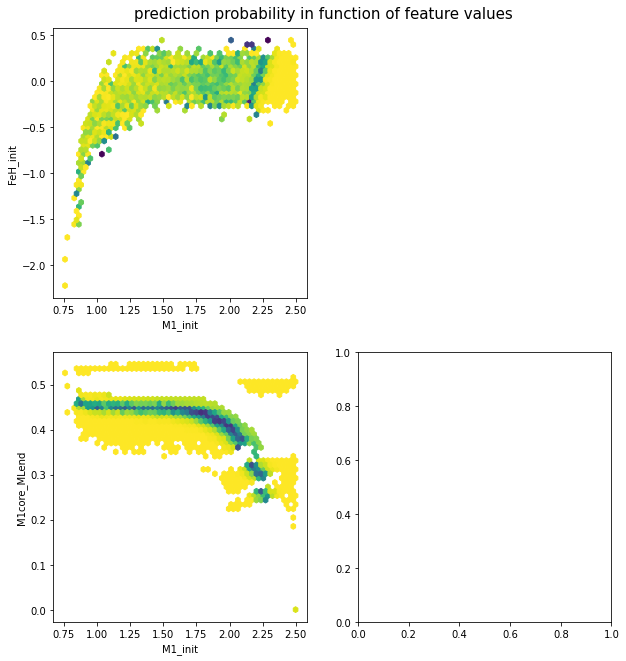

In [38]:
fig = pl.figure(figsize=(10, 10))

fig.suptitle('prediction probability in function of feature values', fontsize=15)

pl.subplots_adjust(top=0.95)

pl.subplot(221)
pl.hexbin(data_pred['M1_init'], data_pred['FeH_init'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('FeH_init')

# pl.subplot(222)
# pl.hexbin(data_pred['M1env_MLend'], data_pred['M1core_MLend'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
# pl.xlabel('M1env_MLend')
# pl.ylabel('M1core_MLend')

pl.subplot(223)
pl.hexbin(data_pred['M1_init'], data_pred['M1core_MLend'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1core_MLend')

pl.subplot(224)

# pl.hexbin(data_pred['M1_init'], data_pred['M1env_MLend'], C=data_pred['probability'], gridsize=50, vmin=0.5, vmax=1)
# pl.xlabel('M1_init')
# pl.ylabel('M1env_MLend')
# pl.colorbar()

In [ ]:
fig = pl.figure(figsize=(10, 10))

fig.suptitle('Error in function of feature values (higher is better)', fontsize=15)

pl.subplots_adjust(top=0.95)

pl.subplot(221)
pl.hexbin(data_pred['M1_init'], data_pred['FeH_init'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('FeH_init')

pl.subplot(222)
pl.hexbin(data_pred['M1env_MLend'], data_pred['M1core_MLend'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1env_MLend')
pl.ylabel('M1core_MLend')

pl.subplot(223)
pl.hexbin(data_pred['M1_init'], data_pred['M1core_MLend'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1core_MLend')

pl.subplot(224)

pl.hexbin(data_pred['M1_init'], data_pred['M1env_MLend'], C=data_pred['error'], gridsize=50, vmin=0, vmax=1)
pl.xlabel('M1_init')
pl.ylabel('M1env_MLend')
pl.colorbar()